Import Libraries

In [2]:
import numpy as np
import seaborn as ans
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Activation,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
#Data augmentation is commonly used in rice leaf disease classification to increase the size and diversity of the training dataset. #
#It involves applying various transformations to the existing images, creating new augmented versions of the original images.#
from tensorflow.keras.preprocessing.image import ImageDataGenerator



#transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

#warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
input_shape_2D=(224,224) # here i'm fixeing the image shape in 2D
input_shape_3D= (224,224,3) # here i'm fixeing the image shape in 2D
seed=1    # assign seed
batch_size=32  #assigning batch size
epochs=30

 Loading image data

In [4]:
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory=r'/content/drive/MyDrive/rice_leaf_diseases',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 120 files belonging to 3 classes.


In [5]:
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


In [6]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

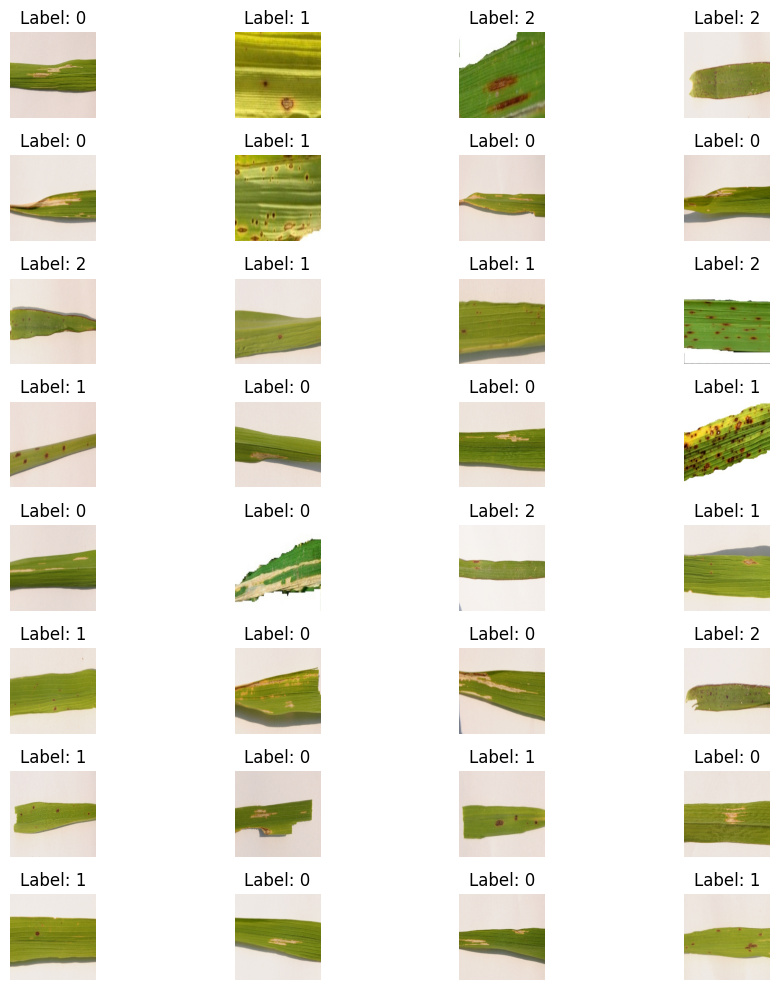

In [7]:
#displaying image batch of 32
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

 Data preprocessing

In [8]:
X=[]
y= []

for image, label in data_ds.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [9]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [11]:
# reshaping the image size

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# getting X_train,X_test,y_train,y_test shape

print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (90, 224, 224, 3)
shape of y_train: (90,)
shape of X_test_scaled: (30, 224, 224, 3)
shape of y_test: (30,)


Encoding


In [12]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

Creating CNN Architecture

In [13]:

model = Sequential()
model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(250,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(3,activation='softmax'))


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      432       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        4608      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18432     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

Train the model

In [15]:
# assigning optimizer,loss and accuracy what we want
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [16]:
checkpointer = ModelCheckpoint(filepath = "model.weights.best.hdf5",save_best_only=False,mode=max,moniter="val_accuracy")

In [17]:
epoch = 30 # assigning epochs and fitting the model with some parameters
history = model.fit(X_train,y_train,batch_size=32,epochs=epoch,validation_data=(X_test,y_test),callbacks=[checkpointer],
              verbose=1,shuffle=True)

Epoch 1/30
3/3 [==============================] - 8s 873ms/step - loss: 1.0977 - accuracy: 0.3111 - val_loss: 1.1545 - val_accuracy: 0.1333
Epoch 2/30
3/3 [==============================] - 0s 68ms/step - loss: 1.0928 - accuracy: 0.3889 - val_loss: 1.1836 - val_accuracy: 0.1333
Epoch 3/30
3/3 [==============================] - 0s 82ms/step - loss: 1.0991 - accuracy: 0.3889 - val_loss: 1.1171 - val_accuracy: 0.1333
Epoch 4/30
3/3 [==============================] - 0s 86ms/step - loss: 1.0843 - accuracy: 0.4222 - val_loss: 1.1380 - val_accuracy: 0.1333
Epoch 5/30
3/3 [==============================] - 0s 82ms/step - loss: 1.0771 - accuracy: 0.4111 - val_loss: 1.1705 - val_accuracy: 0.1333
Epoch 6/30
3/3 [==============================] - 0s 109ms/step - loss: 1.0459 - accuracy: 0.4444 - val_loss: 1.1920 - val_accuracy: 0.1333
Epoch 7/30
3/3 [==============================] - 0s 99ms/step - loss: 1.0612 - accuracy: 0.3889 - val_loss: 1.1286 - val_accuracy: 0.2000
Epoch 8/30
3/3 [=========

In [18]:
scores = model.evaluate(X_test, y_test)  # checking the accuracy
accuracys = 100*scores[1]    # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracys)

1/1 [==============================] - 0s 37ms/step - loss: 2.0806 - accuracy: 0.6333
Test accuracy: 63.3333%


In [19]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()


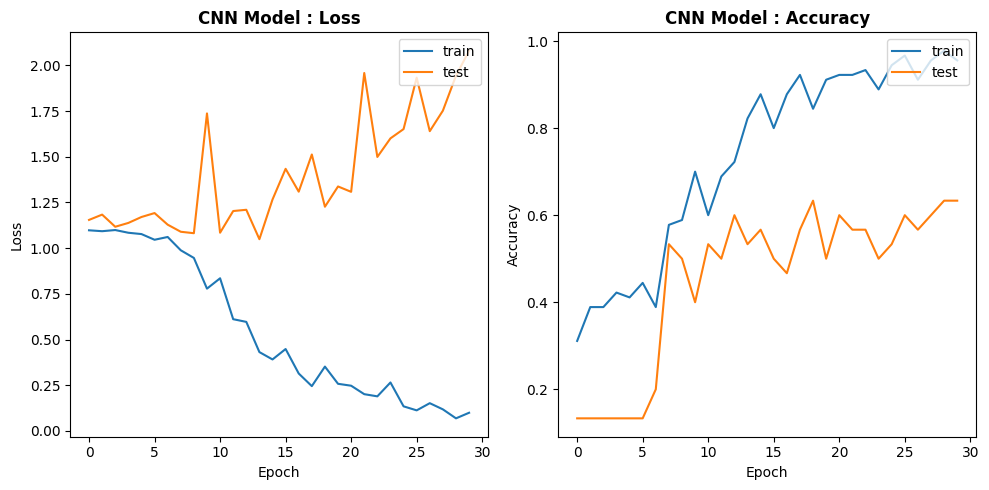

In [20]:
plot_performance(model_name= 'CNN Model',
                 acc=history.history['accuracy'],
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'],
                 val_loss=history.history['val_loss'])

Data Augmentation

In [21]:
#creating image generator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

In [22]:

model1 = Sequential()
model1.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros',input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=3))
model1.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=3))
model1.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=3))
model1.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',strides=(1),activation='relu',use_bias=False,kernel_initializer='glorot_uniform',bias_initializer='zeros'))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.16))
model1.add(Flatten())
model1.add(Dropout(0.27))
model1.add(Dense(500,activation='relu'))
model1.add(Dense(100,activation='relu'))
model1.add(Dense(3,activation='softmax'))


model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 16)      432       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 74, 74, 32)        4608      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18432     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 64)         

In [23]:
# assigning optimizer,loss and accuracy what we want
model1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
#training model with Data Augmentation
epoch1 = 30


checkpointer_own_aug = ModelCheckpoint(filepath='own_model_aug.weights.best.hdf5', verbose=6,moniter="val_accuracy",)

aug_history= model1.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epoch1,
    shuffle=True,
    callbacks=[checkpointer_own_aug]
)

Epoch 1/30
1/2 [==============>...............] - ETA: 3s - loss: 1.1098 - accuracy: 0.2308
Epoch 1: saving model to own_model_aug.weights.best.hdf5
2/2 [==============================] - 4s 556ms/step - loss: 1.1228 - accuracy: 0.1897 - val_loss: 1.1251 - val_accuracy: 0.1333
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 1.0787 - accuracy: 0.4483
Epoch 2: saving model to own_model_aug.weights.best.hdf5
2/2 [==============================] - 1s 497ms/step - loss: 1.0787 - accuracy: 0.4483 - val_loss: 1.2371 - val_accuracy: 0.1333
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 1.1254 - accuracy: 0.3906
Epoch 3: saving model to own_model_aug.weights.best.hdf5
2/2 [==============================] - 1s 451ms/step - loss: 1.1254 - accuracy: 0.3906 - val_loss: 1.2254 - val_accuracy: 0.1333
Epoch 4/30
2/2 [==============================] - ETA: 0s - loss: 1.1259 - accuracy: 0.3276
Epoch 4: saving model to own_model_aug.weights.best.hdf5
2/2 [============

In [24]:
score1 = model1.evaluate(X_test, y_test) # predicting the model
accuracy1 = 100*score1[1] # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy1)

1/1 [==============================] - 0s 49ms/step - loss: 1.4881 - accuracy: 0.2667
Test accuracy: 26.6667%


In [25]:
# define plot for ploting graph of model_name, acc, val_acc, loss, val_loss

def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

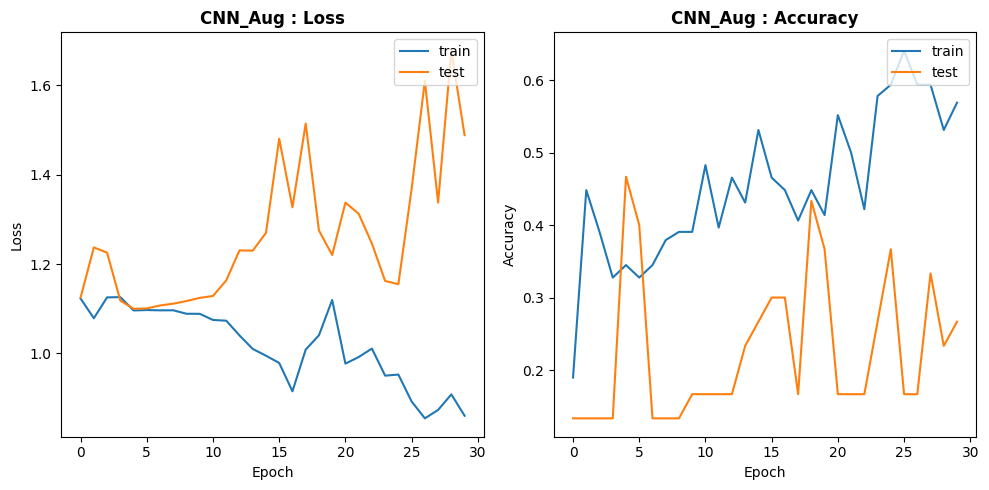

In [26]:
#visualising model performance
plot_performance(model_name='CNN_Aug',
                  acc=aug_history.history['accuracy'],
                 val_acc=aug_history.history['val_accuracy'],
                 loss=aug_history.history['loss'],
                 val_loss=aug_history.history['val_loss'])

Inception V3

In [27]:
inception_base=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape_3D,
)

#unfreezing the convloution layers
inception_base.trainable=True
set_trainable=False

for layer in inception_base.layers:
  if layer.name=='mixed9_0':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True

  else:
    layer.trainable=False


# building fully connected layers
inception_model= Sequential()

inception_model.add(inception_base)
inception_model.add(Flatten())

inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dense(3, activation='softmax'))


#compiling
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 5s 0us/step


In [28]:
# Build the model
def build_inception_model():
    model = Sequential()
    model.add(inception_base)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

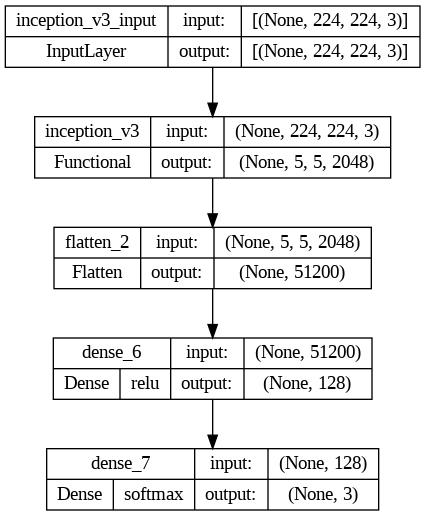

In [29]:
tf.keras.utils.plot_model(
    inception_model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True
)

Without Augmentation

In [30]:
# Train without data augmentation
inception_model = build_inception_model()
checkpointer_inception = ModelCheckpoint(filepath='inception.weights.best.hdf5', verbose=1, save_best_only=True)

inception_history = inception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_inception]
)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 19.8974 - accuracy: 0.2444
Epoch 1: val_loss improved from inf to 7.19145, saving model to inception.weights.best.hdf5
3/3 [==============================] - 21s 5s/step - loss: 19.8974 - accuracy: 0.2444 - val_loss: 7.1915 - val_accuracy: 0.6333
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.8778
Epoch 2: val_loss did not improve from 7.19145
3/3 [==============================] - 0s 164ms/step - loss: 0.6751 - accuracy: 0.8778 - val_loss: 13.4302 - val_accuracy: 0.4333
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 0.9068 - accuracy: 0.8333
Epoch 3: val_loss did not improve from 7.19145
3/3 [==============================] - 0s 123ms/step - loss: 0.9068 - accuracy: 0.8333 - val_loss: 12.4829 - val_accuracy: 0.7000
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000    
Epoch 4: val_loss did not improve from 7.19145
3/3 [=

In [31]:
score2 = inception_model.evaluate(X_test, y_test)
accuracy2 = 100 * score2[1]
print('Test accuracy without augmentation: %.4f%%' % accuracy2)


1/1 [==============================] - 0s 122ms/step - loss: 7.2622 - accuracy: 0.8000
Test accuracy without augmentation: 80.0000%


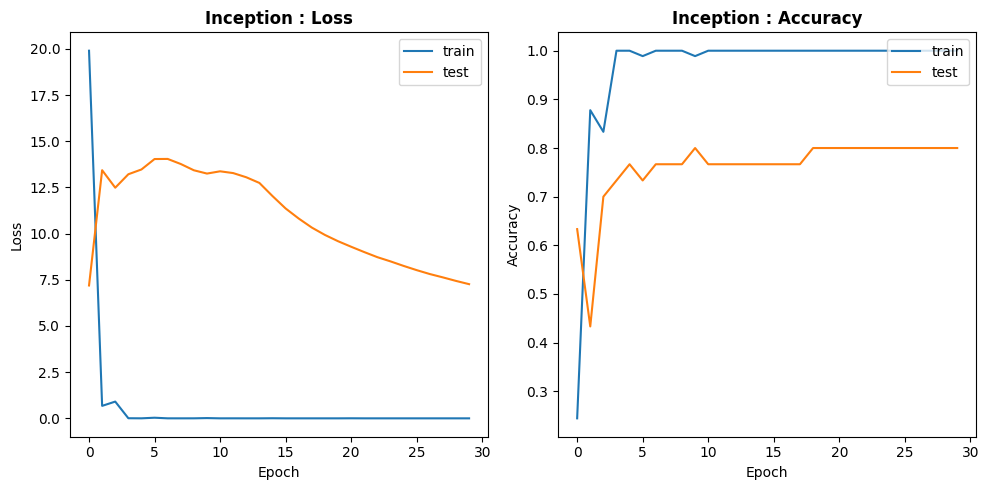

In [32]:
plot_performance(model_name='Inception',
                acc=inception_history.history['accuracy'],
                 val_acc=inception_history.history['val_accuracy'],
                 loss=inception_history.history['loss'],
                 val_loss=inception_history.history['val_loss'])

In [33]:
# Reset model
inception_model = build_inception_model()
checkpointer_inception_aug = ModelCheckpoint(filepath='inception_aug.weights.best.hdf5', verbose=1, save_best_only=True)



With Augmentation

In [34]:

# Train with data augmentation
inception_history_aug = inception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[checkpointer_inception_aug]
)

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 1.2938 - accuracy: 0.5938
Epoch 1: val_loss improved from inf to 9.58410, saving model to inception_aug.weights.best.hdf5
2/2 [==============================] - 10s 2s/step - loss: 1.2938 - accuracy: 0.5938 - val_loss: 9.5841 - val_accuracy: 0.7667
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 2.0056 - accuracy: 0.8125
Epoch 2: val_loss did not improve from 9.58410
2/2 [==============================] - 1s 487ms/step - loss: 2.0056 - accuracy: 0.8125 - val_loss: 14.9765 - val_accuracy: 0.7000
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 1.3342 - accuracy: 0.8276
Epoch 3: val_loss did not improve from 9.58410
2/2 [==============================] - 1s 492ms/step - loss: 1.3342 - accuracy: 0.8276 - val_loss: 19.8018 - val_accuracy: 0.7000
Epoch 4/30
2/2 [==============================] - ETA: 0s - loss: 1.1540 - accuracy: 0.8793
Epoch 4: val_loss did not improve from 9.58410
2/2 [===

In [35]:
score3 = inception_model.evaluate(X_test, y_test)
accuracy3 = 100 * score3[1]
print('Test accuracy with augmentation: %.4f%%' % accuracy3)

1/1 [==============================] - 0s 127ms/step - loss: 18.3168 - accuracy: 0.8333
Test accuracy with augmentation: 83.3333%


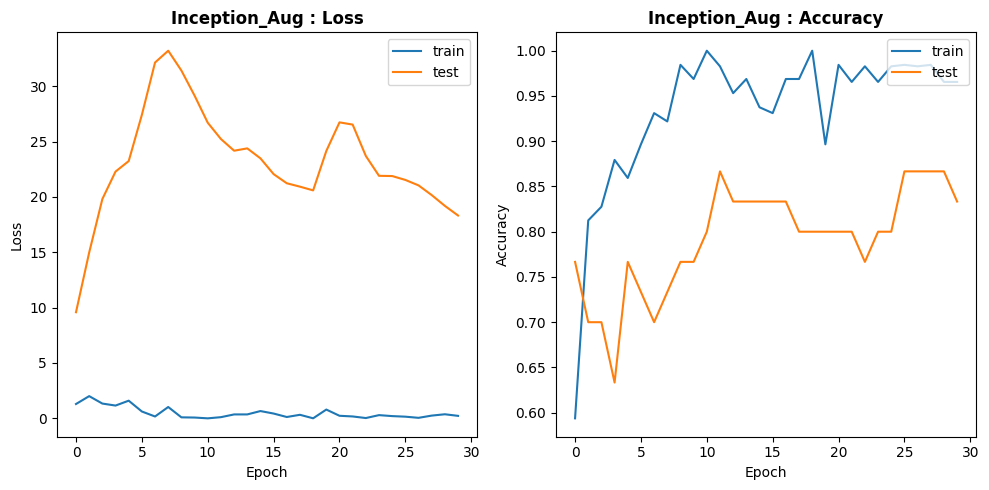

In [36]:

plot_performance(model_name='Inception_Aug',
                acc=inception_history_aug.history['accuracy'],
                 val_acc=inception_history_aug.history['val_accuracy'],
                 loss=inception_history_aug.history['loss'],
                 val_loss=inception_history_aug.history['val_loss'])

Xception

In [37]:

#building fully connected layers
xception_model=Sequential()
xception_base= Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

xception_base.trainable=True
set_trainable=False

for layer in xception_base.layers:
  if layer.name=='add_8':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False


xception_model.add(xception_base)
xception_model.add(Flatten())

xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dense(3, activation='softmax'))

xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 5s 0us/step


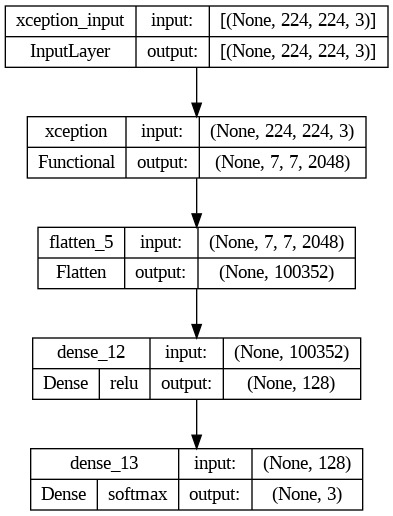

In [38]:
tf.keras.utils.plot_model(
    xception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

Without Augmentation

In [42]:
def build_xception_model():
    xception_base = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape_3D
    )

    xception_base.trainable = True
    set_trainable = False

    for layer in xception_base.layers:
        if layer.name == 'add_8':
            set_trainable = True
        layer.trainable = set_trainable

    model = Sequential()
    model.add(xception_base)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Adjust the number of output classes
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [43]:
xception_model = build_xception_model()
checkpointer_xception = ModelCheckpoint(filepath='xception.weights.best.hdf5', verbose=1, save_best_only=True)

xception_history = xception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_xception]
)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 12.2700 - accuracy: 0.3667
Epoch 1: val_loss improved from inf to 8.67906, saving model to xception.weights.best.hdf5
3/3 [==============================] - 11s 2s/step - loss: 12.2700 - accuracy: 0.3667 - val_loss: 8.6791 - val_accuracy: 0.5667
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 2.2354 - accuracy: 0.7778
Epoch 2: val_loss improved from 8.67906 to 8.65603, saving model to xception.weights.best.hdf5
3/3 [==============================] - 1s 637ms/step - loss: 2.2354 - accuracy: 0.7778 - val_loss: 8.6560 - val_accuracy: 0.4333
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 1.7609 - accuracy: 0.8000
Epoch 3: val_loss improved from 8.65603 to 4.74439, saving model to xception.weights.best.hdf5
3/3 [==============================] - 1s 595ms/step - loss: 1.7609 - accuracy: 0.8000 - val_loss: 4.7444 - val_accuracy: 0.7000
Epoch 4/30
3/3 [==============================] - ETA: 0

In [44]:
score4 = xception_model.evaluate(X_test, y_test) # predicting the model
accuracy4 = 100*score4[1] # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy4)

1/1 [==============================] - 0s 186ms/step - loss: 4.6744 - accuracy: 0.5667
Test accuracy: 56.6667%


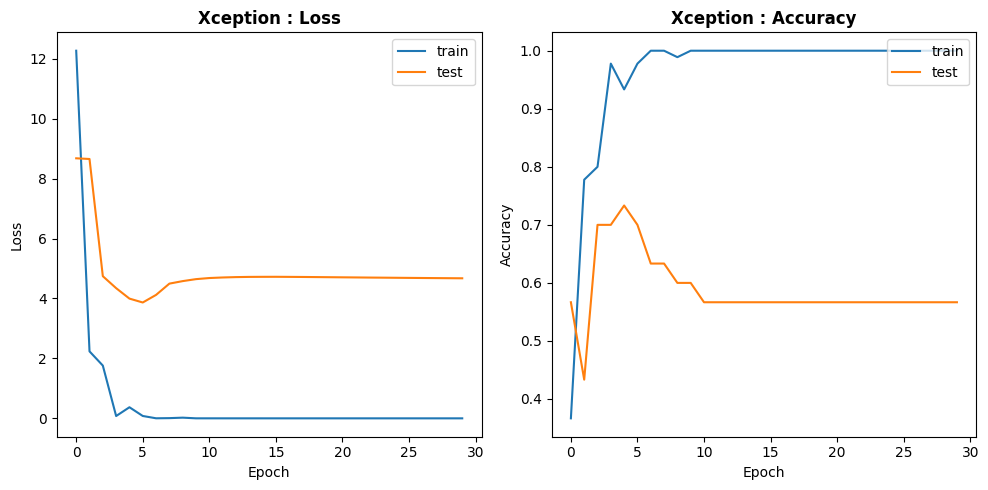

In [45]:
plot_performance(model_name='Xception',
                acc=xception_history.history['accuracy'],
                 val_acc=xception_history.history['val_accuracy'],
                 loss=xception_history.history['loss'],
                 val_loss=xception_history.history['val_loss'])

With Augmentation

In [46]:
xception_model = build_xception_model()
checkpointer_xception_aug = ModelCheckpoint(filepath='xception_aug.weights.best.hdf5', verbose=1, save_best_only=True)

xception_history_aug = xception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[checkpointer_xception_aug]
)

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 6.6722 - accuracy: 0.4655
Epoch 1: val_loss improved from inf to 12.48988, saving model to xception_aug.weights.best.hdf5
2/2 [==============================] - 5s 2s/step - loss: 6.6722 - accuracy: 0.4655 - val_loss: 12.4899 - val_accuracy: 0.4667
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 5.3809 - accuracy: 0.5938
Epoch 2: val_loss improved from 12.48988 to 9.72819, saving model to xception_aug.weights.best.hdf5
2/2 [==============================] - 2s 2s/step - loss: 5.3809 - accuracy: 0.5938 - val_loss: 9.7282 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 4.5374 - accuracy: 0.6406
Epoch 3: val_loss improved from 9.72819 to 2.90731, saving model to xception_aug.weights.best.hdf5
2/2 [==============================] - 2s 2s/step - loss: 4.5374 - accuracy: 0.6406 - val_loss: 2.9073 - val_accuracy: 0.7000
Epoch 4/30
2/2 [==============================] - 

In [47]:
score5 = xception_model.evaluate(X_test, y_test) # predicting the model
accuracy5 = 100*score5[1] # saving the accuracy in variable

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy5)

1/1 [==============================] - 0s 186ms/step - loss: 6.1545 - accuracy: 0.7667
Test accuracy: 76.6667%


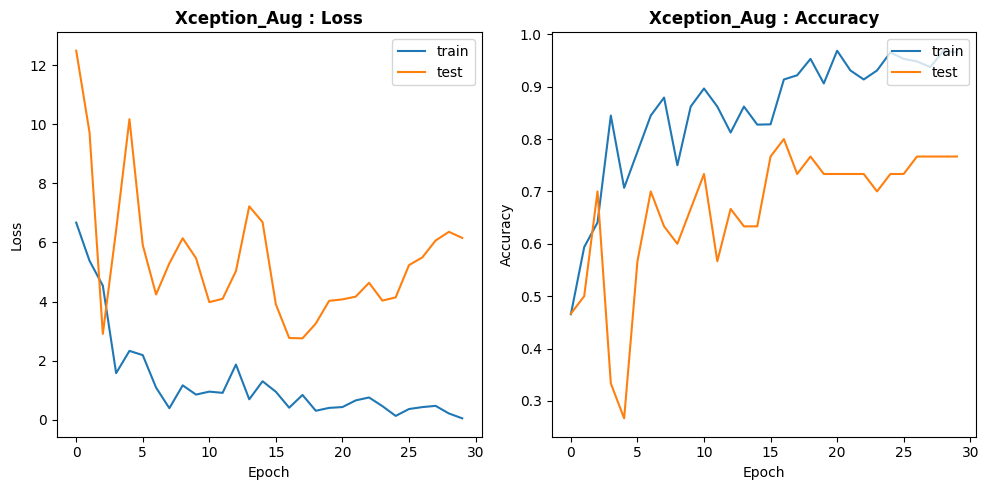

In [48]:
plot_performance(model_name='Xception_Aug',
                acc=xception_history_aug.history['accuracy'],
                 val_acc=xception_history_aug.history['val_accuracy'],
                 loss=xception_history_aug.history['loss'],
                 val_loss=xception_history_aug.history['val_loss'])

In [50]:
# creating dataframe for model camparison
import pandas as pd
score = pd.DataFrame({"Model":["CNN","CNN With Data Augumentaion","InceptionV3 Without Data Augmentation","InceptionV3 With Data Augmentation","Xception Without Data Augmentation","Xception With Data Augmentation"],
                     "accuracy":[accuracys,accuracy1,accuracy2,accuracy3,accuracy4,accuracy5]
                     })


In [51]:
score

,Model,accuracy
0,CNN,63.333333
1,CNN With Data Augumentaion,26.666668
2,InceptionV3 Without Data Augmentation,80.000001
3,InceptionV3 With Data Augmentation,83.333331
4,Xception Without Data Augmentation,56.666666
5,Xception With Data Augmentation,76.666665
